# Apprendimento di insieme

Nella parte precedente abbiamo visto come come ottimizzare un modello e come valutarlo. Qui ci concentreremo sulla costruzione di un insieme di classificatori che porta un risultato migliore del classificatore singolo.

Esistono più sitemi per combinare più classificatore al fine di creare un metaclassificatore, il più semplice metodo è il cosidetto voto a maggioranza dove si seleziona la classe che ricevuto più del 50% dei voti.

Allargando il concetto a problemi multiclasse si ottiene il concetto di pluralità, qui sotto un esempio di voto a maggioranza e pluralità.

![votazioni](./images/votazioni.png "Votazioni")

Utilizzando l'insieme di addestramento di inizia la fase di train degli *m* classificatori (dello stesso tipo o differenti) $(C_{1},...,C_{m})$ per ottenere il voto finale si combinano le previsioni dei vari classificatori selezionando la classe che ha ottenuto il maggior numero di voti $\hat{y}$.

$$\hat{y} = mode \left\{ C_{1}(x),...,C_{n}(x) \right\}$$

Ma perchè un metodo di insieme funziona meglio di un singolo classificatore? 
Semplificando il problema supponiamo che tutti gli $n$ classificatori abbiamo un tasso di errore pari a $\varepsilon$,siano indipendenti e che i tassi di errore non siano correlati tra loro. 

Con queste supposizione possiamo suppore che la probabilità di errore di un insieme di classificatori sia esprimibile come una distribuzione binomiale.

$$P(y>k) = \sum_{k}^{n} \binom{n}{k} \varepsilon^{k} (1-\varepsilon)^{n-k}$$

In altre parole calcoliamo la probabilità che la previsione d'insieme sia errata.
Facciamo un esempio concreto, supponiamo di avere 11 classificatori e che il tasso di errore sia 0.25, se 6 classificatori danno lo stesso risultato avremo come risultato

$$P(y>k) = \sum_{k=6}^{11} \binom{11}{k} \varepsilon^{k} (1-\varepsilon)^{11-k} = 0.034$$

Come si evince abbiamo un risultato che ha un tasso di errore molto inferiore del classificatore singolo.

In [2]:
from scipy.special import comb
import math

def enseble_error(n_classifier,error,k_start = None):
    if k_start is None:
        k_start = math.ceil(n_classifier / 2.0)
    
    probs = [comb(n_classifier,k) * (error ** k) * (1 - error) ** (n_classifier - k) for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [3]:
enseble_error(11,0.25)

0.03432750701904297

Dopo aver implementato la funzione `enseble_error` possiamo calcolare i tassi di errore d'insieme per un intervallo di errore che va da 0.0 a 1.0 e confrontando l'errore singolo con l'errore di insieme.



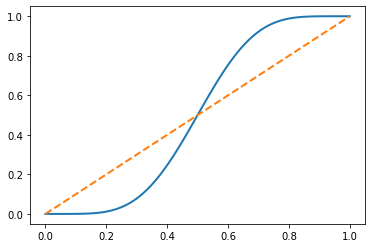

In [4]:
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0,1.01,0.01)
enseble_errors = [enseble_error(n_classifier=11,error=error) for error in error_range]

plt.plot(error_range,enseble_errors,label='Ensemble error',linewidth=2)
plt.plot(error_range,error_range,linestyle="--",label='Base Error',linewidth=2)

Come possiamo vedere se il tasso di errore dell'insieme è sempre migliore se $\varepsilon < 0.5$ 

## Implementazione di un classificatore con voto a maggioranza

in questa parte implementiamo un semplice algoritmo di *"voto a maggioranza"*, con l'obiettivo di costruire un metaclassificatore che compensi i punti deboli di un singolo classificatore.

Ad ogni classificatore singolo verrà associato un peso che andrà a costruire la votazione finale.
Traduciamo il concetto in python per rendere la spiegazione più comprensibile:

In [5]:
votes = [0,0,1]
w = [0.2,0.2,0.6]

np.argmax(np.bincount(votes,weights = w))


1

possiamo implementare anche un metaclassificatore che restituisca la probabilità delle etichiette come visto in passato, qui sotto un esempio di codice.

In [6]:
probs = [[0.9,0.1],
         [0.8,0.2],
         [0.4,0.6]]


p = np.average(probs,axis=0,weights = w)

Uniamo quello che abbiamo visto in una unica classe

In [7]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier
    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble
    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).
    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.
        y : array-like, shape = [n_examples]
            Vector of target class labels.
        Returns
        -------
        self : object
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.
        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.
        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out


Ora sebbene questa classe possa sembrare completa e pronta per la produzione, si consigli per tali scopi di utilizzare le classi messe a disposizione da sklearn nel pacchetto: `sklearn.ensemble.VotingClassifier`

## Combinare gli algoritmi per la classificazione a voto di maggioranza

Cominciamo ad utilizzare nella pratica la classe implementata, caricando il dataset iris, con solo due caratteristiche *petal width* e *petal lenght* per complicare il problema.

In [8]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

Tramite il dataset di addestramento utilizzeremo tre metodi di classificazione e li uniremo tramite il nostro metaclassficatore

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [10]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


In [11]:
from sklearn.ensemble import VotingClassifier

eclf1 = VotingClassifier(estimators=[('lr', pipe1), ('decision', clf2), ('kn', pipe3)], voting='soft')

scores = cross_val_score(estimator=eclf1,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')

print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), "VotingClassifier"))

ROC AUC: 0.98 (+/- 0.05) [VotingClassifier]


come possiamo vedere le prestazioni del metaclassificatore sono migliori del classificatore singolo.

## Valutazione e ottimizzazione del classificatore di insieme

Controlliamo ora tramite le corve roc se il nostro metaclassificatore `MajorityVoteClassifier` generalizza bene su dati mai visti prima.

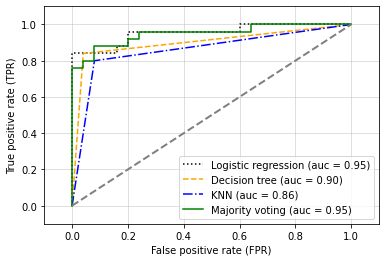

In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

Come possiamo vedere il metaclassificatore si comporta bene anche sul dataset di test (ROC UAC = 0.95) mentre il metodo KNN sembra avere qualche problemino di overfitting. 

Visto che abbiamo solo due features visualizziamo la regione decisionale dei vari modelli. 
Per una questione di praticità andiamo a standardizzare il dataset di test per tutti i modelli in modo da poter confrontarli

In [13]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

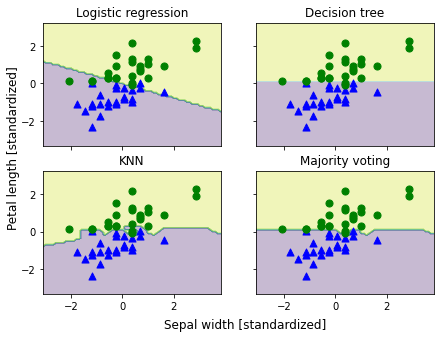

In [14]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.show()

Come si vede, la regione decisionale del classificatore di insieme sembra essere un ibrido delle regioni decisionali delle regioni decisionali dei classificatori singoli.

Prima di ottimizzare i singoli parametri chiamiamo `get_params` peravere accesso ai singoli parametri.

In [15]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

Sulla base di quella chiamata ora sappiamo come accedere ai parametri dei singoli classificatori al fine di ottimizzare l'intero sistema andremo ad ottimizzare i parametri della regressione logistica e del classificatore KNN

In [16]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [17]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
Accuracy: 0.98


come promemoria va ricordato che usare il dataset di test più volte non è un comportamento corretto, in questo caso lo abbiamo utilizzato solo a scopo informativo.

Il metodo che abbiamo usato si chiama anche stacking.

Analizziamo ora un approccio alternativo chiamato anche *bagging*.

## Bagging, costruire un insieme di classificatori da un campione di bootstrap

Il bagging è una tecnica di apprendimento di insieme simile a quanto visto prima, tuttavia invece di utilizzare lo stesso set di addestramento per tutti i classificatori si estraggono dal set di addestramento dei campioni di bootstrap (con inserimento).

Per capire il funzionamento guardiamo l'immagine qui sotto, qui abbiamo 7 istanze di addestramento da uno a sette, per ogni turno andiamo a campionare il dataset con reinserimento 

| Indici campione | Turno Bagging 1 | Turno Bagging 2 | Turno Bagging n |
| --- | --- | --- | --- |
| 1 | 2 | 7 | ... |
| 2 | 2 | 3 | ... |
| 3 | 1 | 2 | ... |
| 4 | 3 | 1 | ... |
| 5 | 7 | 1 | ... |
| 6 | 2 | 7 | ... |
| 7 | 4 | 7 | ... |
| **Classificatore** | C1 | C2 | Cn |

Ad ogni turno viene poi viene addestrato un classficato $C_j$ che normalmente è un albero decisionale non potato, il bagging è in correlazione con le foreste casuali già viste in passato.

Per vedere in azione il bagging creiamo un problema di classificazione complicando un dataset già utilizzato.


In [18]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

Dividiamo in due parti il dataset test e train

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

Andiamo poi ad utilizzare il bagging classifier con 500 alberi decisionali e creiamo un albero decisionale non potato per il confronto

In [20]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [21]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.917


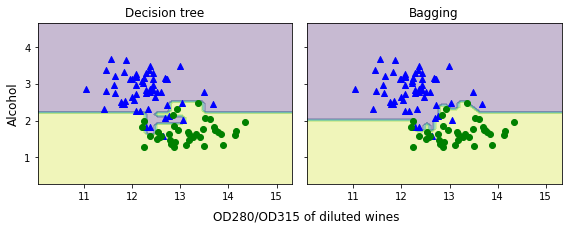

In [22]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('images/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

## Adaptive Boost

In questo ultimo paragrafo parleremo dell'adaptive boost, con questa tecnica vengono usati classificatori molto semplici *(weak learner)* i quali hanno un debole vantaggio rispetto ad un classificatore casuale. 

Un tipico esempio di classificatore potrebbe essere un moncone di albero decisionale. 
Il concetto su cui si basa il boosting sta nel concentrarsi sui campioni difficili da classificare,la procedura può essere riassunta così:

* Estrarre senza reinserimento dal dataset $D$ un sottoinsieme casuale di campioni d'addestramento $d_1$ per addestrare un sistema di apprendimento debole $C_1$

* Estrarre un secondo campione senza reinserimento $d_2$ aggiungendo il 50% dei campioni mal classificati del dataset $d_1$ e addestrare il secondo classificatore $C_2$

* Trovare i campioni del dataset $d_3$ partendo dal dataset $D$ in cui $C_1$ e $C_2$ non concordano in modo da addestrare un terzo sistema $C_3$.

* Con questi risultati si utilizzano i sistemi $C_1$ , $C_2$ e $C_3$ tramite voto a maggioranza

Il sistema di boosting porta ad una riduzione del bias e della varianza ma bisogna prestare molta attenzione all'overfitting.
Al contrario di quanto descritto precedentemente la tecnica di adaboost lavora sul dataset completo per addestrare i sistemi di apprendimento dove i campioni vengono ripesati a ogni iterazione in modo da costruire un classificatore più efficace.

Vediamo l'immagine qui sotto

![Adaboost](./images/adaboost.png)

Partiamo dal riquardo 1, dove si vede un dataset di classificazione binario, tutti i campioni ricevono pesi uguali.
A questa dataset applichiamo un moncone decisionale (rappresentato dalla linea tratteggiata). 

Al turno successivo assegnamo un peso maggiore ai due campioni che in precedenza erano stati mal classificati e riduciamo il peso dei campioni classificati correttamente. Il secondo moncone decisionale si concentrerà sui campioni di addestramento che hanno un peso maggiore, si suppone che siano quelli difficili da classificare.

Ora i campioni mal classificati sono i tre cerchi ai quali viene assegnato un peso maggiore nel nuovo ciclo di classificazione.
Supponendo che il nostro algoritmo sia composto da soli tre turni di boosting possiamo ora combinare i risultati al turno 4 come da immagine.

Passiamo ora ad un approfondimento dell'algoritmo dando uno sguardo al pseudocodice, per chiarezza andremo a indicare la moltipicazione elemento per elemento con il simbolo $\times$ mentre andremo ad indicare il prodotto scalare con il simbolo $\cdot$

1. Imposto il vettori dei pesi $w$ da dare ad ogni riga del dataset in modo uniforme in modo tale che $\sum_{i=1}^{n} w_i = 1$
2. Per ogni turno j di boosting eseguire i seguenti passi:
- Eseguire la fase di train del classificatore debole $C_j = train(x,y,w)$
- Eseguo la fase di predict $\hat{y} = predict(C_j,x)$
- Calcolo il tasso di errore pesato $\varepsilon = w \cdot (\hat{y} \neq y)$
- Calcolo il coefficiente $\alpha_i = 0.5 \log(\frac{1 - \varepsilon}{\varepsilon})$
- Aggiornare i pesi $w = w \times \exp(-\alpha_j \times \hat{y} \times y)$
- Normalizzazione dei pesi $w$ sempre in modo tale che $\sum_{i=1}^{n} w_i = 1$
3. Calcolo la previsione finale $\hat{y} = ( \sum_{j=1}^{m} (\alpha_i \times predict(C_j,X)) > 0 )$

Nota importante l'espressione $\hat{y} == y$ indica il vettore di 1 e 0 dove 1 indica una previsione corretta e 0 la previsione errata.

Sebbene questo sistema possa sembrare semplice vediamo l'applicazione su un dataset di 10 elementi.

![dataset](./images/dataset.png "dataset")

La seconda colonna della tabella rappresenta gli indici dei campioni di addestramento da 1 a 10, 
La terza colonna rappresenta l'etichetta della classe y con valori -1 e 1
La quarta colonna contiene il valore dei pesi di partenza.
La quinta colonna mostra la previsione $\hat{y}$ supponendo che il nostro criterio di classificazione sia $x \leq 3.0$.
L'ultima colonna rappresenta l'aggiornamento dei pesi dopo l'elaborazione.

### Esempio di aggiornamento dei pesi
Iniziamo con il calcolo del valore $\varepsilon$ nel seguente modo:

$$\varepsilon = (0.1 \times 0) + (0.1 \times 0) + (0.1 \times 0) + (0.1 \times 0) + (0.1 \times 0) + (0.1 \times 0) + (0.1 \times 1) + (0.1 \times 1) + (0.1 \times 1) + (0.1 \times 0) = \frac{3}{10} = 0.3$$

Calcoliamo poi l'indice $\alpha_j$ che verrà utilizzato per adattare i pesi del classificatore e nel voto di maggioranza finale

$$\alpha_j = 0.5 \log \left( \frac{1 - 0.3}{0.3} \right) \approx 0.424  $$

ora con tale coeffieciente andiamo ad aggiornare i pesi del vettore utilizzando l'equazione se l'equazione vista prima, analizziamo i due casi:

Nel caso la previsione sia corretta avremo un decremento del peso relativo all'elemento del vettore $w$ come esempio:

$$ 0.1 \times \exp \left(-0.424 \times 1 \times 1 \right) \approx 0.066 $$

Nel caso la previsione non sia corretta avremo un incremente del peso come esempio:

$$ 0.1 \times \exp \left(-0.424 \times 1 \times -1 \right) \approx 0.153 $$

L'ultimo passo è rappresentato dalla normalizzazione dei pesi :

$$\frac{w}{\sum_{i=1}^{n} w_i}$$

Con 

$$\sum_{i=1}^{n} w_i = 7 \times 0.066 + 3 \times 0.153 = 0.914$$

Ora per ogni campione correttamente classificato avremo che il suo peso sarà ridotto da $0.1$ a $0.066 / 0.914 \approx 0.072$
Mentre per ogni campione non classifcato correttamente avremo in incremento da $0.1$ a $0.153 / 0.914 \approx 0.167$

Questo è un esempio di adaboost passiamo ora alla parte più pratica, riutilizzimo il dataset wine visto prima addestrando 500 tronconi di alberi decisionali

In [23]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [24]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 1.000/0.917


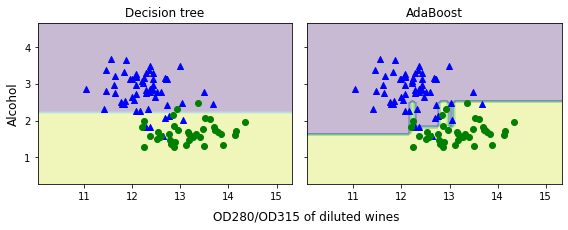

In [25]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('images/07_11.png', dpi=300, bbox_inches='tight')
plt.show()